<a href="https://colab.research.google.com/github/Aki-373/eizou_media/blob/main/GradCAM%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
import PIL
from matplotlib import pyplot as plt
import cv2

In [75]:
from google.colab import files
uploaded_file = files.upload()

uploaded_file_name = next(iter(uploaded_file))
print(uploaded_file_name)

Saving 24096713_s.jpg to 24096713_s.jpg
24096713_s.jpg


In [76]:
class VGG16(torch.nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        features = list(models.vgg16(pretrained = True).features)
        classifier = list(models.vgg16(pretrained = True).classifier)
        self.features = nn.ModuleList(features).eval() 
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.flatten = nn.Flatten()
        self.classifier = nn.ModuleList(classifier).eval() 
        
    def forward(self, x):
        for model in self.features:
            x = model(x)
        feature = x
        x = self.avgpool(x)
        x = self.flatten(x)
        for model in self.classifier:
          x = model(x)
        return x, feature

In [77]:
transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ])

transform2 = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
    ])

In [78]:
vgg16 = VGG16()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


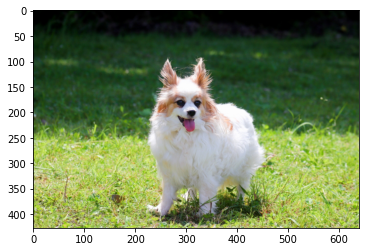

In [79]:
img = PIL.Image.open(uploaded_file_name)
plt.imshow(img)

img = transform(img)
img = img.unsqueeze(0)

In [80]:
output, feature = vgg16(img)
pred = np.argmax(output[0].detach().numpy())
Yc = output[0, pred]

feature.retain_grad()
Yc.backward()

grad = feature.grad[0]
print(grad.shape)
first = (torch.exp(Yc)*grad).detach().numpy()
second = (torch.exp(Yc)*grad*grad).detach().numpy()
third = (torch.exp(Yc)*grad*grad*grad).detach().numpy()
feature = feature.detach().numpy()
feature = np.squeeze(feature)

alpha = second / (2*second + third*np.sum(feature.reshape((-1, first.shape[2])), axis=0))
alpha /= np.sum(np.sum(alpha, axis=0), axis=0).reshape((1, 1, first.shape[2]))

w = np.sum((alpha * np.maximum(0, first)).reshape((-1, first.shape[0])), axis=0)
w = w.reshape(-1,1,1)

L = np.maximum(0, np.sum(w*feature, axis=0))
L /= np.max(L)

torch.Size([512, 7, 7])


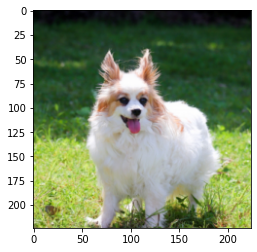

In [81]:
img = PIL.Image.open(uploaded_file_name)
img = transform2(img)
img = img.detach().numpy()
img = img.transpose(1,2,0)
plt.imshow(img)

In [82]:
CAM = cv2.resize(L, (224, 224), cv2.INTER_LINEAR)
CAM = cv2.applyColorMap(np.uint8(255 * CAM), cv2.COLORMAP_JET) 
CAM = np.float32(cv2.cvtColor(CAM, cv2.COLOR_BGR2RGB))
CAM = (CAM/510 + img/2) 

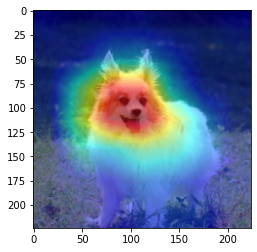

In [83]:
plt.imshow(CAM)